In [1]:
# Acessa ao Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# importa os pacotes necessarios
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2025-05-03 17:28:52.898168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746293333.103015      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746293333.164488      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# # Verifica a imagem dos dados em npy
# def plot_numpy_matrix(npy_file, time_scale_factor=1):
#     """
#     Plots the numpy matrix as an image.
#     """
#     data = np.load(npy_file)
#     num_samples, num_traces = data.shape
#     print(data.shape)


#     # Definindo o fator de escala para o eixo y (tempo)
#     time_scale = np.arange(num_samples) * time_scale_factor

#     plt.figure(figsize=figsize)
#     plt.imshow(data, cmap='gray', aspect='auto', extent=[0, num_traces, time_scale[-1], time_scale[0]])
#     plt.colorbar(label='Amplitude')
#     plt.xlabel('Trace')
#     plt.ylabel('Time (ms)')
#     plt.title('SEGY Data')
#     plt.show()

# def plot_numpy_matrices_in_folder(folder, time_scale_factor=1):
#     """
#     Plots numpy matrices in the given folder.
#     """
#     for file in os.listdir(folder):
#         if file.endswith('.npy'):
#             npy_file = os.path.join(folder, file)
#             print("Plotting matrix from:", npy_file)
#             plot_numpy_matrix(npy_file, time_scale_factor)

# # Substitua 'caminho_da_sua_pasta' pelo caminho da pasta que contém os arquivos numpy
# folder_path = '/content/'
# # Fator de escala de tempo duplo (por exemplo, 2 para escala de tempo duplo)
# figsize = (18, 6)
# time_scale_factor = 1
# plot_numpy_matrices_in_folder(folder_path, time_scale_factor)

In [4]:
# # Imagem da mascara feito pelos pesquisadores na area de geologia UFRN
# imageMascara = '/content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/Mascara_210_4.png'
# # Ler a imagem com três canais
# imgMascara = cv2.imread(imageMascara)
# imgMascara = cv2.cvtColor(imgMascara, cv2.COLOR_BGR2RGB)
# # Verificar se as imagens foram carregadas corretamente
# if imgMascara is None:
#     print("Erro ao carregar uma ou ambas as imagens!")
# else:
#     # Mostrar as imagens lidas
#     plt.figure(figsize=(18, 6))  # Configura o tamanho total da figura
#     plt.subplot(1, 2, 1)
#     plt.imshow(imgMascara, aspect='auto')
#     plt.title('Máscara da Imagem')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


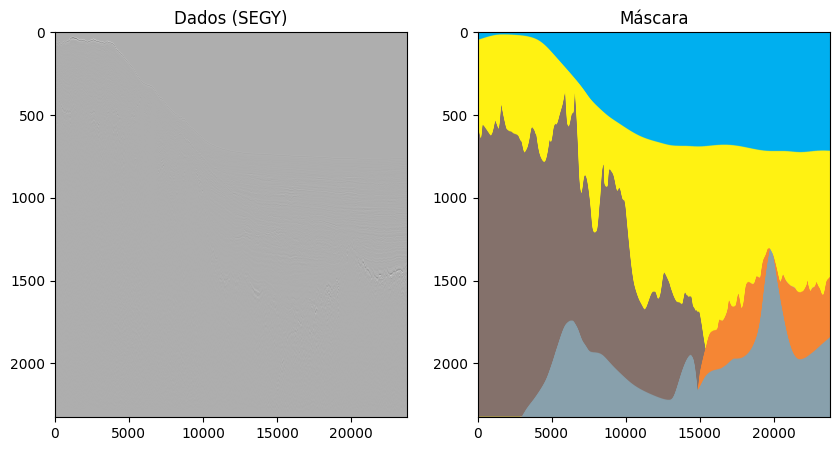

In [5]:
# verificando ambas imagens (arquivo npy do dado e a mascara construida)
import matplotlib.pyplot as plt

image_data = np.load('/kaggle/input/aprendizadomaquina/BB08RE11-210-PRCMIG.npy')
imageMascara = '/kaggle/input/aprendizadomaquina/Mascara_210_4 (1).png'
# Ler a imagem com três canais
imgMascara = cv2.imread(imageMascara)
imgMascara = cv2.cvtColor(imgMascara, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_data, cmap='gray', aspect='auto')
plt.title('Dados (SEGY)')

plt.subplot(1, 2, 2)
plt.imshow(imgMascara, aspect='auto')  # Mantendo a cor
plt.title('Máscara')

plt.show()


In [6]:
# Certificando que ambos estão na msm dimensão
print("Dimensão do dado original:", image_data.shape)
print("Dimensão da máscara:", imgMascara.shape)

Dimensão do dado original: (2326, 23777)
Dimensão da máscara: (2326, 23777, 3)


libpng warning: iCCP: known incorrect sRGB profile


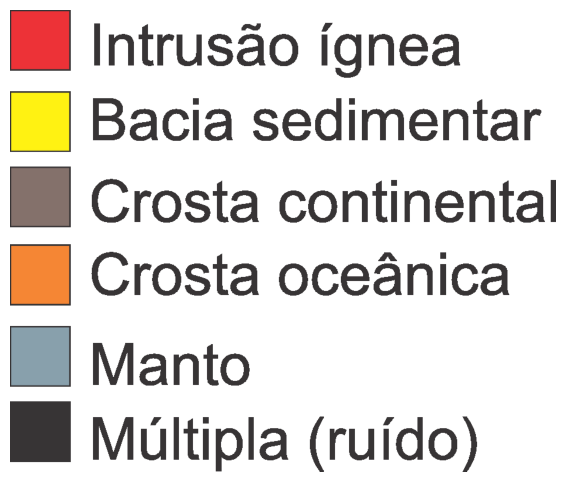

In [7]:
# Verificando a legenda, para saber qual classe pertence a sua cor
legenda = '/kaggle/input/aprendizadomaquina/legenda.png'
legenda = cv2.imread(legenda)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(legenda, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Inserindo atributos nos dados

In [8]:
from scipy.ndimage import uniform_filter, gaussian_filter, sobel
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
import numpy as np

# Garantir imagem 2D (caso tenha um canal extra)
if image_data.ndim > 2:
    image = image_data[:, :, 0]
else:
    image = image_data

# Atributo 1: Amplitude (valor absoluto)
attr_amplitude = np.abs(image)

# Atributo 2: Variância local
local_mean = uniform_filter(image, size=7)
local_sqr_mean = uniform_filter(image**2, size=7)
attr_variance = local_sqr_mean - local_mean**2

# Atributo 3: Entropia local
image_ubyte = img_as_ubyte((image - image.min()) / (image.max() - image.min()))
attr_entropy = entropy(image_ubyte, disk(5))

# Atributo 4: Gradiente (sobel)
attr_gradient = np.hypot(sobel(image, axis=0), sobel(image, axis=1))

# Atributo 5: Média local (gaussiano)
attr_gauss = gaussian_filter(image, sigma=3)

# Empilhar todos os atributos (como canais)
attr_stack = np.stack([
    attr_amplitude,
    attr_variance,
    attr_entropy,
    attr_gradient,
    attr_gauss
], axis=-1)

# Verificar dimensões
print("Dimensões da imagem com atributos:", attr_stack.shape)

Dimensões da imagem com atributos: (2326, 23777, 5)


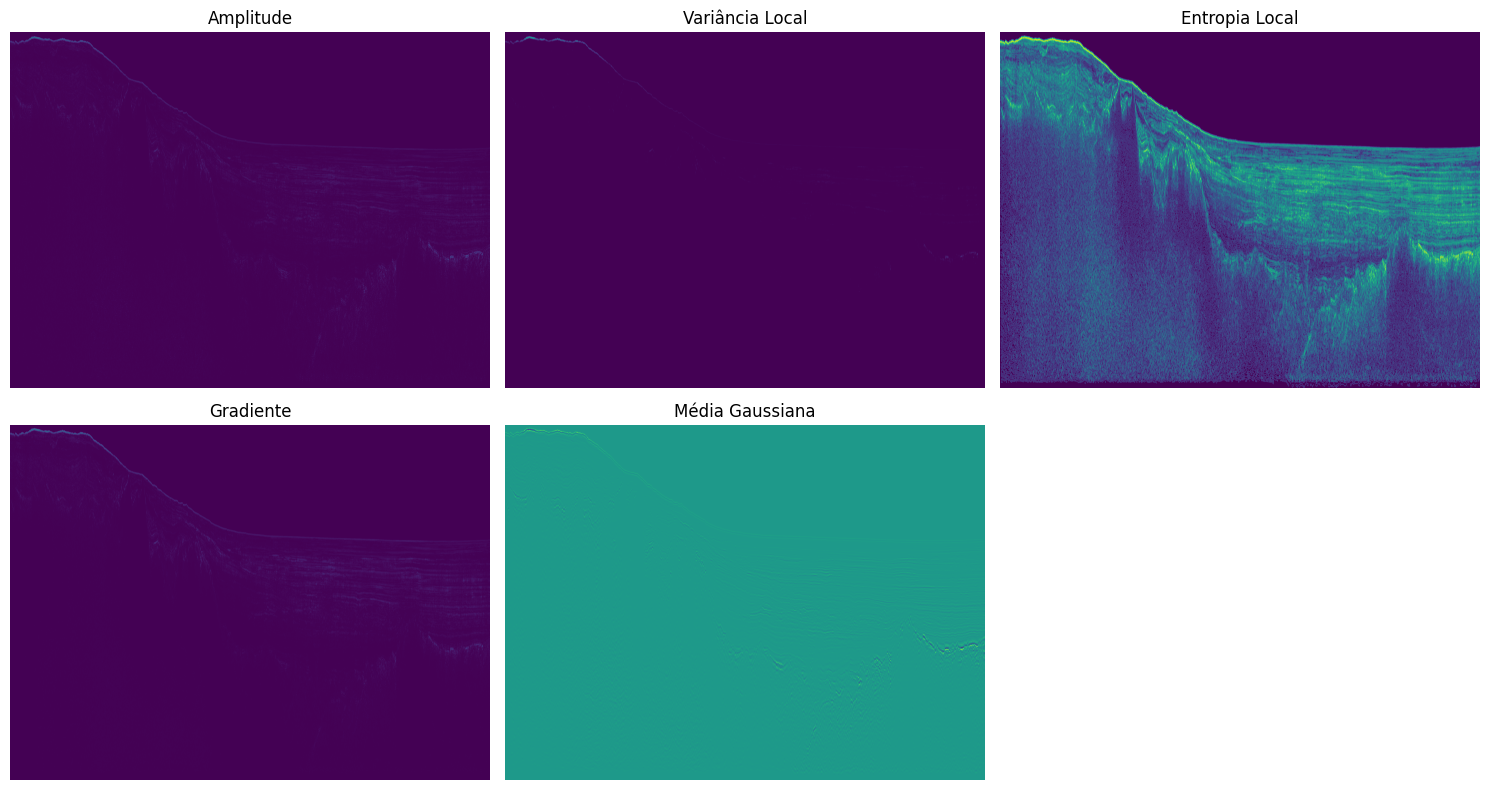

In [9]:
# Lista com os nomes dos atributos e os arrays correspondentes
attr_names = ['Amplitude', 'Variância Local', 'Entropia Local', 'Gradiente', 'Média Gaussiana']

plt.figure(figsize=(15, 8))

for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(attr_stack[:, :, i], cmap='viridis', aspect='auto')
    plt.title(attr_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Começar a dividir os patches com seus labels

In [10]:
# Foi usado ferramenta para verificar o RGB dos pixel das classes
color_to_class = {
    (0, 175, 239): 'agua',  # Azul
    (255, 242, 18): 'bacia sedimentar',  # Amarelo
    (132, 113, 107): 'crosta continental',  # Marrom
    (245, 134, 52): 'crosta oceanica',  # Laranja
    (136, 160, 172): 'manto'  # Cinza
}

In [11]:
# Função para encontrar a classe predominante em um patch
def get_dominant_class(patch, color_to_class):
    # Reformatar o patch para (N, 3) para facilitar a contagem de cores
    reshaped_patch = patch.reshape(-1, 3)
    unique_colors, counts = np.unique(reshaped_patch, axis=0, return_counts=True)

    # Encontrar a cor predominante
    dominant_color = unique_colors[np.argmax(counts)]

    # Mapear para a classe correspondente
    return color_to_class.get(tuple(dominant_color), 'unknown')  # Retorna 'unknown' se a cor não estiver mapeada

In [12]:
# Codigo para dividir em patches, verificar a maior quantidade de pixel presente na mascara de acordo com a informação acima e atribuir o rotulo correspondente
# # Caminho do arquivo .npy
# image_npy_path = '/content/drive/MyDrive/newProjetoMeco/BB08RE11-210-PRCMIG/BB08RE11-210-PRCMIG.npy'

# # Carregar a imagem .npy
# image_data = np.load(image_npy_path)

height, width = attr_stack.shape[:2]
patch_size = (64, 64)

# Ajustar para múltiplos de 64
new_height = (height // patch_size[0]) * patch_size[0]
new_width = (width // patch_size[1]) * patch_size[1]

# Recortar atributos e máscara para tamanhos ajustados
adjusted_attr_stack = attr_stack[:new_height, :new_width, :]
adjusted_mask = imgMascara[:new_height, :new_width, :]

# Dividir os atributos e a máscara em patches
attr_patches = []
mask_patches = []

for i in range(0, new_height, patch_size[0]):
    for j in range(0, new_width, patch_size[1]):
        # Extrair patches dos atributos (com 5 canais) e da máscara
        attr_patch = adjusted_attr_stack[i:i+patch_size[0], j:j+patch_size[1], :]  # shape: (64, 64, 5)
        mask_patch = adjusted_mask[i:i+patch_size[0], j:j+patch_size[1], :]        # shape: (64, 64, 3)

        attr_patches.append(attr_patch)
        mask_patches.append(mask_patch)

# Garantir que os números de patches são iguais
assert len(attr_patches) == len(mask_patches), "Número de patches de atributos e máscara não corresponde!"

# Determinar os rótulos com base na máscara
patch_labels = [get_dominant_class(patch, color_to_class) for patch in mask_patches]

# Verificar
print("Total de patches (atributos):", len(attr_patches))
print("Total de patches (máscara):", len(mask_patches))
print("Classes encontradas:", set(patch_labels))

Total de patches (atributos): 13356
Total de patches (máscara): 13356
Classes encontradas: {'bacia sedimentar', 'agua', 'crosta continental', 'crosta oceanica', 'manto'}


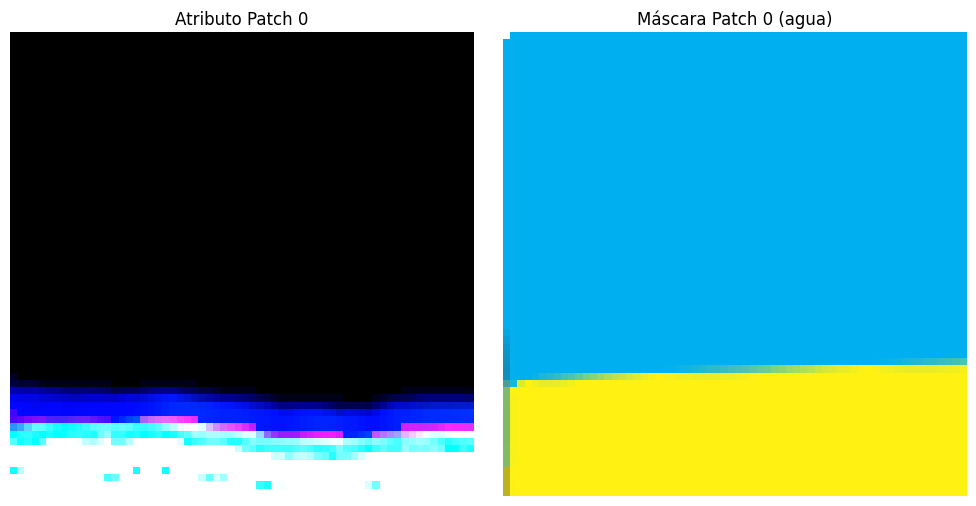

Dimensão do patch atributo: (64, 64, 5)
Dimensão do patch máscara: (64, 64, 3)


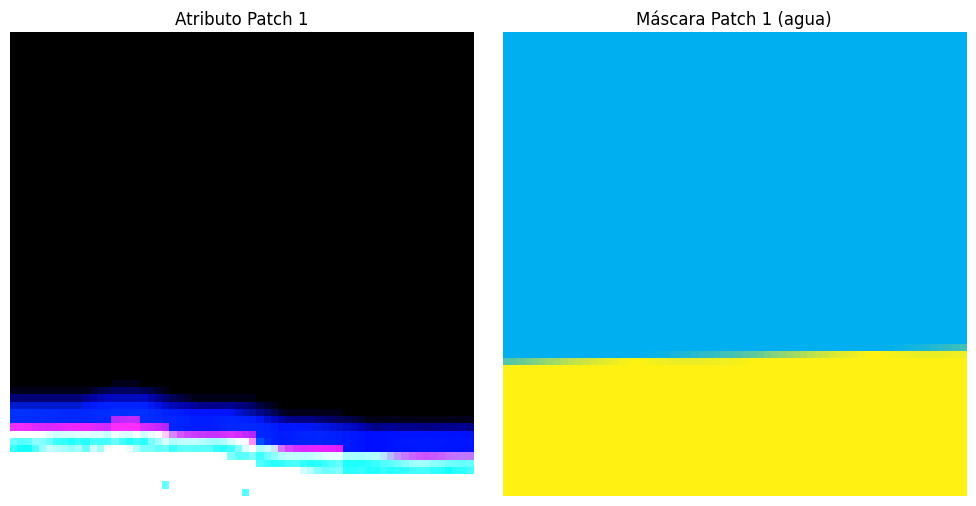

Dimensão do patch atributo: (64, 64, 5)
Dimensão do patch máscara: (64, 64, 3)


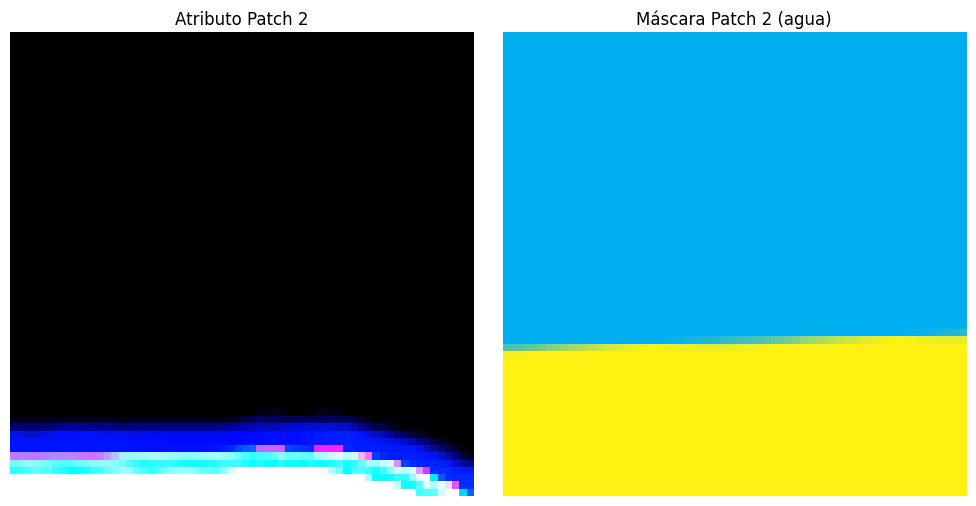

Dimensão do patch atributo: (64, 64, 5)
Dimensão do patch máscara: (64, 64, 3)


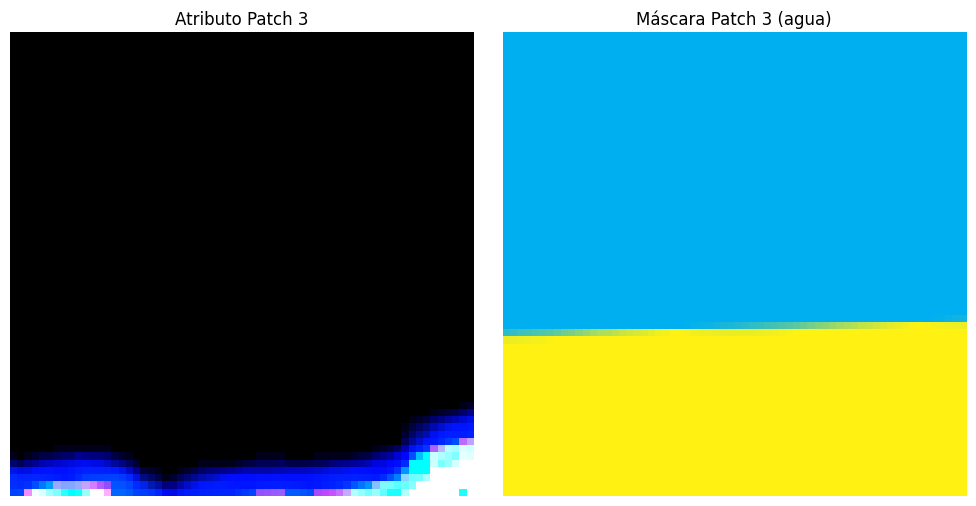

Dimensão do patch atributo: (64, 64, 5)
Dimensão do patch máscara: (64, 64, 3)


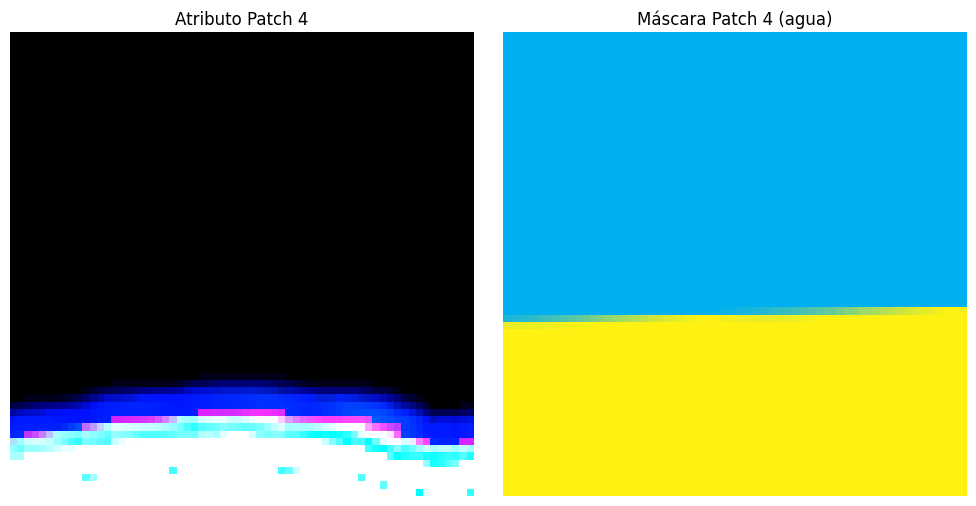

Dimensão do patch atributo: (64, 64, 5)
Dimensão do patch máscara: (64, 64, 3)


In [13]:
import matplotlib.pyplot as plt

# Visualizar um patch (pode-se escolher o canal 0 ou um RGB fake)
def display_patch(attr_patch, mask_patch, label, patch_idx):
    plt.figure(figsize=(10, 5))

    # Patch do atributo (exibindo os 3 primeiros canais como RGB se possível)
    plt.subplot(1, 2, 1)
    if attr_patch.ndim == 3 and attr_patch.shape[2] >= 3:
        plt.imshow(attr_patch[:, :, :3])  # Exibe como RGB
    elif attr_patch.ndim == 3:
        plt.imshow(attr_patch[:, :, 0], cmap='gray')  # Mostra só o 1º canal
    else:
        plt.imshow(attr_patch, cmap='gray')
    plt.title(f"Atributo Patch {patch_idx}")
    plt.axis('off')

    # Patch da máscara
    plt.subplot(1, 2, 2)
    plt.imshow(mask_patch)
    plt.title(f"Máscara Patch {patch_idx} ({label})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Testar visualizando alguns patches
for idx in range(5):
    display_patch(attr_patches[idx], mask_patches[idx], patch_labels[idx], idx)
    print("Dimensão do patch atributo:", attr_patches[idx].shape)
    print("Dimensão do patch máscara:", mask_patches[idx].shape)

In [14]:
# verificando a quantidade presente em cada classe
from collections import Counter
class_counts = Counter(patch_labels)
for class_name, count in class_counts.items():
    print(f"Classe '{class_name}': {count} patches")

Classe 'agua': 2813 patches
Classe 'bacia sedimentar': 4231 patches
Classe 'crosta continental': 4016 patches
Classe 'crosta oceanica': 627 patches
Classe 'manto': 1669 patches


In [15]:
# fazendo a divisão em treino, teste e validação
from sklearn.model_selection import train_test_split
import numpy as np

# Convertendo os novos patches e rótulos balanceados para arrays numpy
X_balanced = np.array(attr_patches)
y_balanced = np.array([list(color_to_class.values()).index(label) for label in patch_labels])

X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de validação: {len(X_val)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

Tamanho do conjunto de treino: 9349
Tamanho do conjunto de validação: 2003
Tamanho do conjunto de teste: 2004


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Junta os conjuntos de treino e validação
X_train_final = np.concatenate([X_train, X_val], axis=0)
y_train_final = np.concatenate([y_train, y_val], axis=0)

# Flatten dos patches para vetores (necessário para modelos tradicionais)
X_train_flat = X_train_final.reshape(X_train_final.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

## Verificando modelo 1


In [17]:
# --- Modelo 1: Decision Tree ---
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_flat, y_train_final)

y_pred_dt = dt_model.predict(X_test_flat)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Acurácia (Decision Tree) no conjunto de teste: {acc_dt:.4f}")

Acurácia (Decision Tree) no conjunto de teste: 0.6946


## Verificando modelo 2

In [18]:
# --- Modelo 2: k-Nearest Neighbors ---
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_flat, y_train_final)

y_pred_knn = knn_model.predict(X_test_flat)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Acurácia (k-NN, k=5) no conjunto de teste: {acc_knn:.4f}")

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Acurácia (k-NN, k=5) no conjunto de teste: 0.7620
